# Getting setup

This notebook requires xcdat and xsearch. We will also show an example using the [eofs](https://ajdawson.github.io/eofs/latest/index.html#) package. To produce the xcdat environment using Conda:

```
conda create -n xcdat -c conda-forge xcdat xesmf eofs ipykernel ipython
conda activate xcdat
```

To enable xsearch in Jupyter, run:

```
python -m ipykernel install --user --name xcdat --display-name xcdat
```

[xsearch](https://github.com/pochedls/xsearch/) can be downloaded directly from GitHub. Alternatively, we maintain a version that can be added to your `PYTHONPATH`. To do this, add the following to your `.bashrc` or `.bash_profile`:

```
export PYTHONPATH="$PYTHONPATH:/p/user_pub/xclim/persist/software/"
export JUPYTER_PATH="$JUPYTER_PATH:/p/user_pub/xclim/persist/software/"
```

Note that on LC machines, the path include `/climate/`: `/p/climate/user_pub/xclim/persist/software/`

# Import the relevant libraries

* Find and process data
    * xsearch allows us to query local CMIP holdings
    * xcdat allows us to read and proce"ss CMIP data
    * urllib to download remote ECS data
    * json to read in json ECS data
* Utilities
    * numpy for random numerical calculations
    * datetime simply to print the time
    * tqdm for progress tracking
* Plotting
    * matplotlib / cartopy for displaying results

In [1]:
import xcdat as xc
import xsearch as xs
import numpy as np
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime
import tqdm
from sklearn.decomposition import PCA

# Get model historical data

Let's see if we can look at how the leading pattern of warming in models scales with ECS (as in Tokarska et al. 2020). We specify the experiment, variable, and frequency. For LC machines, we need to add the option `lcpath=True`. You can specify other optional arguments, e.g., `mip_era`, too. Check out the documentation for a full list of optional arguments.

In [2]:
dpaths = xs.findPaths('historical', 'tas', 'mon', mip_era='CMIP6', lcpath=True)

Multiple values for cmipTable. Consider filtering by cmipTable.
Available values: Amon, ImonGre, ImonAnt

Multiple values for realm. Consider filtering by realm.
Available values: atmos, landIce



### This results in a warning that datasets span multiple realms and CMIP tables. You can refine your search with optional arguments.

In [3]:
dpaths = xs.findPaths('historical', 'tas', 'mon', mip_era='CMIP6', lcpath=True, cmipTable='Amon', realm='atmos')

### This produces a dictionary where each key is a dataset path. The dictionary contains metadata about each dataset.

In [4]:
key_path = list(dpaths.keys())[0]  # get first path
print(key_path)  # print path

# print metadata for that path
print()
for key in dpaths[key_path].keys():
    print(key + ': ' + str(dpaths[key_path][key]))

/p/climate/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1/historical/r1i1p1f1/Amon/tas/gr/v20191211/

keyid: CMIP6.CMIP.E3SM-Project.E3SM-1-1.historical.r1i1p1f1.Amon.atmos.mon.tas.gr.glb-z1-gr.v20191211
mip_era: CMIP6
activity: CMIP
institute: E3SM-Project
model: E3SM-1-1
experiment: historical
member: r1i1p1f1
cmipTable: Amon
realm: atmos
frequency: mon
variable: tas
grid: gr
gridLabel: glb-z1-gr
version: v20191211
timepoints: 120
nfiles: 17
nc_creation_date: 20191211
sumfilesize_bytes: 381258003
has_zero_size_files: 0
created: 2021-04-23 20:12:34
modified: 2021-04-23 20:12:34
accessed: 2022-10-04 15:22:40
retired: 0
retire_datetime: None
retracted: 0
retracted_datetime: None
ignored: 0
ignored_datetime: None
comment: None
unique: True
alternate_paths: ['/p/climate/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/historical/r1i1p1f1/Amon/tas/gr/v20191211/']


### We can summarize the query by finding all elements for a given search facet

In [5]:
models = xs.getGroupValues(dpaths, 'model')
models.sort()
for model in models[0:10]:
    print(model)
print('...')

ACCESS-CM2
ACCESS-ESM1-5
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
CESM2
CESM2-FV2
...


### Using the data

We're going to show an example where we compute the surface air temperature trends for a given model. We'll then apply this to a bunch of models in order to compute the leading intermodel EOF and how the principal component from that analysis scales with climate sensitivity (similar to [Tokarska et al. 2020, Fig. 4](https://www.science.org/doi/10.1126/sciadv.aaz9549)). 

### We'll start by loading the data and subsetting it to the satellite era (1979 - 2014). 

In [6]:
model = 'E3SM-1-0'
model_dataset = xs.getValuesForFacet(dpaths, 'model', model)[0]
ds = xc.open_mfdataset(model_dataset + '*.nc')
ds_subset = ds.sel(time=slice("1979-01-01", "2014-12-30"))

### Now lets compute the annual average

In [7]:
# compute annual average
ds_subset_aa = ds_subset.temporal.group_average("tas", freq="year", weighted=True)

### Now compute the global mean time series and trend (and plot result!)

The trend is: 0.29565344423858153 K/decade


Text(0, 0.5, 'Global Temperature [K]')

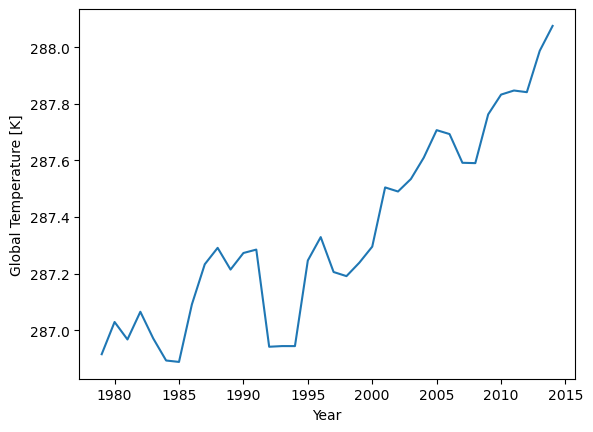

In [8]:
# compute global average time series and trend
tsg = ds_subset_aa.spatial.average("tas").tas  # global average series

time = np.arange(1979, 2015)  # time vector
gt, _ = np.polyfit(time, tsg, 1)  # get trend
gt *= 10  # to K/decade units
print('The trend is: ' + str(gt) + ' K/decade')

plt.plot(time, tsg); plt.xlabel('Year'); plt.ylabel('Global Temperature [K]')

### Now regrid the data to a 2.5 x 2.5 degree grid

In [9]:
# define target 2.5 x 2.5 degree grid
nlat = np.arange(-88.75, 90, 2.5)
nlon = np.arange(1.25, 360, 2.5)
target_grid = xc.create_grid(nlat, nlon)

# execute regrid
ds_regrid = ds_subset_aa.regridder.horizontal('tas', target_grid, tool='xesmf', method='bilinear')

### Now we compute the linear trend at each grid point

In [10]:
tas = np.reshape(np.array(ds_regrid.tas), (len(time), -1))  # reshape into [time, space]
trend_xy, _ = np.polyfit(time, tas, 1)  # compute linear trend
trend_xy = np.reshape(trend_xy, (len(nlat), len(nlon)))  # reshape into [1, lat, lon]
trend_xy = trend_xy * 10  # units to K/decade

### Plot the map as a sanity check

Text(0.5, 1.0, 'GMST Trend (E3SM-1-0)')

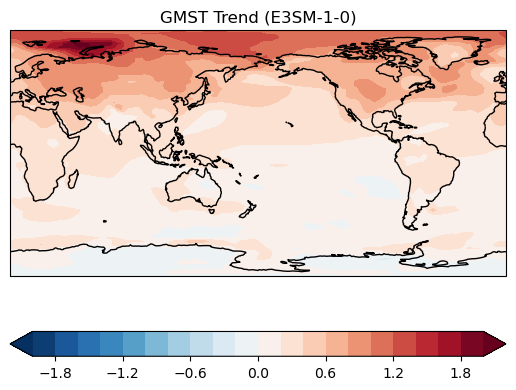

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
im = ax.contourf(nlon, nlat, trend_xy, 
                 transform=ccrs.PlateCarree(), 
                 levels=np.arange(-2., 2.1, 0.2), 
                 cmap=plt.cm.RdBu_r, 
                 extend='both')
ax.coastlines()
plt.colorbar(im, orientation='horizontal')
plt.title('GMST Trend (' + model + ')')

### Grab ECS data and store it into a dictionary

In [12]:
ecs_url = "https://raw.githubusercontent.com/mzelinka/cmip56_forcing_feedback_ecs/master/cmip56_forcing_feedback_ecs.json"
  
# load remote ECS dataset
ecsjson = json.loads(urlopen(ecs_url).read())

ecsDict = {}
for model in ecsjson['CMIP6'].keys():
    members = list(ecsjson['CMIP6'][model].keys())
    if len(members) > 1:
        member = [m for m in members if 'r1i1p1' in m][0]
    else:
        member = members[0]
    e = ecsjson['CMIP6'][model][member]['ECS']
    ecsDict[model] = e
    

### Now let's repeat this for all of the models and store the results in a dictionary.

In [13]:
print(datetime.datetime.now())
trend_maps = {}  # initialize dictionary
global_trends = {}
# loop over all models with ECS data
models = [model for model in models if model in ecsDict.keys()]
for i, model in tqdm.tqdm(enumerate(models)):
    # get model data directory (just grab the first dataset)
    model_dataset = xs.getValuesForFacet(dpaths, 'model', model)[0]
    # open dataset
    ds = xc.open_mfdataset(model_dataset + '*.nc')
    # subset to satellite era
    ds_subset = ds.sel(time=slice("1979-01-01", "2014-12-30"))
    # take annual average
    ds_subset_aa = ds_subset.temporal.group_average("tas", freq="year", weighted=True)
    # global average / trend calculation
    tsg = ds_subset_aa.spatial.average("tas").tas  # global average series
    gt, _ = np.polyfit(time, tsg, 1)  # get trend
    gt *= 10  # to K/decade units
    global_trends[model] = gt
    # regrid
    ds_regrid = ds_subset_aa.regridder.horizontal('tas', target_grid, tool='xesmf', method='bilinear')
    # compute trend pattern
    trend_xy, _ = np.polyfit(time, np.reshape(np.array(ds_regrid.tas), (len(time), -1)), 1)
    trend_map = np.reshape(trend_xy, (len(nlat), len(nlon)))
    trend_maps[model] = trend_map
print(datetime.datetime.now())

2022-11-03 16:47:24.218547


6it [00:49,  7.49s/it]/g/g14/pochedls/bin/anaconda3/envs/xcdat/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
7it [00:55,  6.85s/it]/g/g14/pochedls/bin/anaconda3/envs/xcdat/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
8it [00:57,  5.36s/it]/g/g14/pochedls/bin/anaconda3/envs/xcdat/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
9it [01:02,  5.41s/it]/g/g14/pochedls/bin/anaconda3/envs/xcdat/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to N

2022-11-03 16:53:41.293417


### We now collect the data into vectors for analysis

In [14]:
# collect the data into vectors
trend_maps_list = []
ecslist = []
global_trend_list = []
for model in trend_maps.keys():
    trend_maps_list.append(trend_maps[model])
    ecslist.append(ecsDict[model])
    global_trend_list.append(global_trends[model])
trend_maps_array = np.array(trend_maps_list)
ecs_array = np.array(ecslist)
global_trends_array = np.array(global_trend_list)

### Perform PCA

In [15]:
shp = trend_maps_array.shape  # get array shape
X = np.reshape(trend_maps_array, (shp[0], shp[1]*shp[2]))  # reshape into (samples, features)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)  # standardize
# perform PCA
skpca = PCA()
skpca.fit(X)
# collect eofs and pcs
pcs = skpca.transform(X)
eofs = skpca.components_

### Show Leading EOF

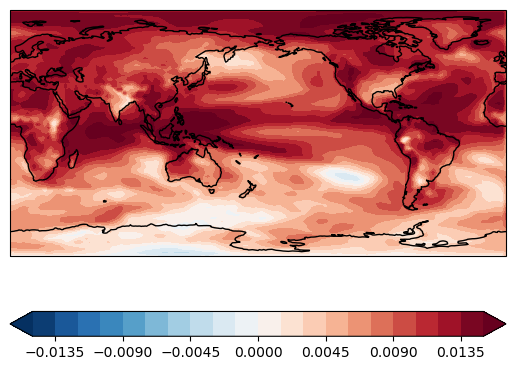

In [16]:
eof1 = np.reshape(eofs[0, :], (shp[1], shp[2]))
# plt.subplot(1, 2, 1)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180.0))
im = ax.contourf(nlon, nlat, eof1, 
                 transform=ccrs.PlateCarree(), 
                 levels=np.arange(-0.015, 0.016, 0.0015), 
                 cmap=plt.cm.RdBu_r, 
                 extend='both')
ax.coastlines()
plt.colorbar(im, orientation='horizontal')

### Compare GMST change and PC1 to ECS

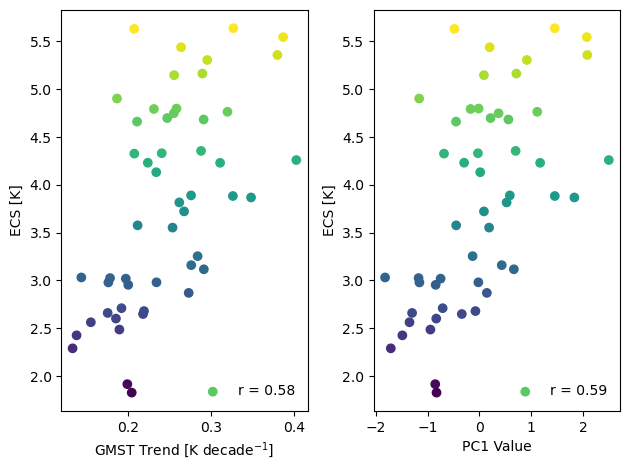

In [17]:
plt.subplot(1, 2, 1)
r = np.corrcoef(global_trends_array, ecs_array)[0, 1]
rstring = 'r = ' + '{0:.2f}'.format(np.round(r, 2))
plt.scatter(global_trends_array, ecs_array, c=ecs_array, label=rstring)
plt.xlabel('GMST Trend [K decade$^{-1}$]')
plt.ylabel('ECS [K]')
plt.legend(frameon=False)

plt.subplot(1, 2, 2)
pc1 = pcs[:, 0]
r = np.corrcoef(pc1, ecs_array)[0, 1]
rstring = 'r = ' + '{0:.2f}'.format(np.round(r, 2))
plt.scatter(pc1 / np.std(pc1), ecs_array, c=ecs_array, label=rstring)
plt.xlabel('PC1 Value')
plt.ylabel('ECS [K]')
plt.legend(frameon=False)
plt.tight_layout()